In [2]:
import subprocess
import numpy as np
import sgoop
import scipy.optimize as opt
import time
import matplotlib.pyplot as plt
import random

gro_file = "npt.gro"
traj_file = "md1.xtc"
plumed_file = "input.plu"
tmp_colvar = ".colvar"
shell_file = "plumed.log"
bashCommand = "plumed driver --plumed " + plumed_file + " --mf_xtc " + traj_file
rmCommand = "rm bck.*." + tmp_colvar

In [3]:
class OrderParameter:

    def __init__(self, i, j, traj):
        self.i = i
        self.j = j
        self.traj = traj
        
    def __str__(self):
        return str(self.i)

In [4]:
# Parse through .gro file and returns array of alpha carbons
def find_alpha_carbons(gro_file):

    f = open(gro_file, "r")
    alpha_carbons = []

    # Reads title string and number of atoms and ignores them
    f.readline()
    f.readline()

    # Iterates through each line corresponding to an atom
    for i in f:

        comps = i.split()

        # Checks if atom is an alpha carbon
        if comps[1] == "CA":
            alpha_carbons.append(int(comps[2]))

    f.close()
    return alpha_carbons

In [5]:
# Binning values of one order parameter to create a 1 dimensional probability space
def d1_bin(x, bins = 80):

    min_val = np.amin(x)
    max_val = np.amax(x)
    span = max_val - min_val

    p_x = [0.0 for i in range(bins)]

    for i in x:
        bin_num = (int) (bins * (i - min_val) / span)
        if bin_num == bins:
            bin_num -= 1
        p_x[bin_num] += 1.0 / len(x)

    return p_x

In [6]:
# Binning valus of two order parameters to create a 2 dimensional probability space
def d2_bin(x, y, bins = 80):

    if len(x) != len(y):
        raise Exception("Order parameter lists are of different size.")

    min_x = np.amin(x)
    max_x = np.amax(x)
    span_x = max_x - min_x

    min_y = np.amin(y)
    max_y = np.amax(y)
    span_y = max_y - min_y

    p_xy = [[0.0 for i in range(bins)] for j in range(bins)]

    for i in range(len(x)):
        bin_x = (int) (bins * (x[i] - min_x) / span_x)
        bin_y = (int) (bins * (y[i] - min_y) / span_y)
        if bin_x == bins:
            bin_x -= 1
        if bin_y == bins:
            bin_y -= 1
        p_xy[bin_x][bin_y] += 1.0 / len(x)

    return p_xy

In [7]:
# Calculates normalized mutual information of two order parameters
def mutual_info(x, y, bins = 100):

    p_x = d1_bin(x, bins)
    p_y = d1_bin(y, bins)
    p_xy = d2_bin(x, y, bins)

    info = 0
    entropy = 0

    for i in range(len(p_x)):
        for j in range(len(p_y)):
            if p_xy[i][j] != 0:
                entropy -= p_xy[i][j] * np.log(p_xy[i][j])
                info += p_xy[i][j] * np.log(p_xy[i][j] / (p_x[i] * p_y[j]))

    return (1 - (info / entropy))

In [8]:
# Finds the number of local maxima in a noisy probability distribution
def find_wells(prob):

    energy = []
    for i in (range(len(prob))):
        if prob[i] == 0:
            energy.append(np.inf)
        else:
            energy.append(-1 * np.log(prob[i]))

    wells = 0
    max = np.inf
    min = np.inf
    d = 1
    i = 0
    for x in energy:
        if x > max:
            max = x
            if (max - min > 1):
                min = x
                d = 1
        elif x < min:
            min = x
            if (max - min > 1):
                if d == 1:
                    wells = wells + 1
                max = x
                d = -1
        i = i + 1

    return wells

In [19]:
def opti_func(rc):
    global nfev, data_array
    nfev +=1
    return -sgoop.rc_eval(rc, data_array)

In [36]:
def print_fun(x, f, accepted):
    global now,last,nfev,lastf
    now=time.time()
    #print(x,end=' ')
    #if accepted == 1:
    #    print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    #else:
    #    print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev

In [11]:
def initial_guess(wells, num_ops, data_array):
    
    x = [-1 for i in range(num_ops)]
    finished = [1 for i in range(num_ops)]
    rc = x
    max_val = 0
    sgoop.wells = wells
    
    while not x == finished:
        
        tmp = sgoop.rc_eval(x, data_array)
        if tmp > max_val:
            max_val = tmp
            rc = x.copy()
            
        for i in range(num_ops):
            if x[num_ops - 1 - i] == -1:
                x[num_ops - 1 - i] = 1
                break;
            else:
                x[num_ops - 1 - i] = -1
                
    tmp = sgoop.rc_eval(x, data_array)
    if tmp > max_val:
        max_val = tmp
        rc = x.copy()
        
    return rc

In [58]:
# Generating random numbers
x = []
x2 = []
x4 = []
x5 = []
xm1 = []
xm4 = []
y = []
y2 = []
y4 = []
y5 = []
ym1 = []
ym4 = []
z = []
w = []
a = []
a2 = []
a3 = []
am1 = []
am2 = []
am3 = []
b = []
b2 = []
b3 = []
bm1 = []
bm2 = []
bm3 = []
c = []
d = []
e = []
f = []
for i in range(50000):
    tmp1 = random.random()
    tmp1 = 1 - (tmp1 * tmp1 * tmp1 * tmp1)
    if random.random() < 0.5:
        tmp1 = -1 * tmp1
    tmp2 = random.random()
    tmp2 = (tmp2 * tmp2 * tmp2 * tmp2)/2
    if random.random() < 0.5:
        tmp2 = 1 - tmp2
    if random.random() < 0.5:
        tmp2 = -1 * tmp2
    tmp3 = random.random()
    tmp3 = 1 - (tmp3 * tmp3 * tmp3 * tmp3)
    if random.random() < 0.5:
        tmp3 = -1 * tmp3
    tmp4 = random.random()
    tmp4 = 1 - (tmp4 * tmp4 * tmp4 * tmp4)
    if random.random() < 0.5:
        tmp4 = -1 * tmp4
    tmp5 = random.random()
    tmp5 = 1 - (tmp5 * tmp5 * tmp5)
    if random.random() < 0.5:
        tmp5 = -1 * tmp5
    x.append(tmp1)
    x2.append(tmp1 * 2)
    x4.append(tmp1 * 4)
    x5.append(tmp1 * 5)
    xm1.append(tmp1 * (-1))
    xm4.append(tmp1 * (-4))
    y.append(tmp2)
    y2.append(tmp2 * 2)
    y4.append(tmp2 * 4)
    y5.append(tmp2 * 5)
    ym1.append(tmp2 * (-1))
    ym4.append(tmp2 * (-4))
    z.append(tmp3)
    w.append(5 * tmp1 + tmp2)
    a.append(tmp4)
    a2.append(tmp4 * 2)
    a3.append(tmp4 * 3)
    am1.append(tmp4 * (-1))
    am2.append(tmp4 * (-2))
    am3.append(tmp4 * (-3))
    b.append(tmp5)
    b2.append(tmp5 * 2)
    b3.append(tmp5 * 3)
    bm1.append(tmp5 * (-1))
    bm2.append(tmp5 * (-2))
    bm3.append(tmp5 * (-3))
    c.append(4 * tmp2 + tmp5)
    d.append(tmp3 + 5 * tmp4)
    e.append(tmp3 + tmp4 + 4 * tmp5)
    f.append(10 * tmp1 + tmp2 + tmp3 + tmp4 + tmp5)

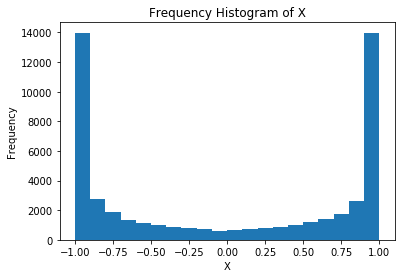

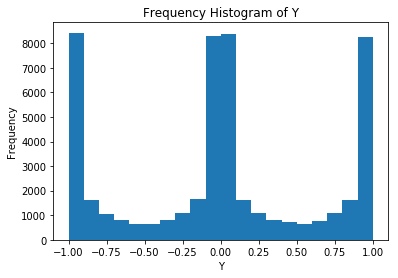

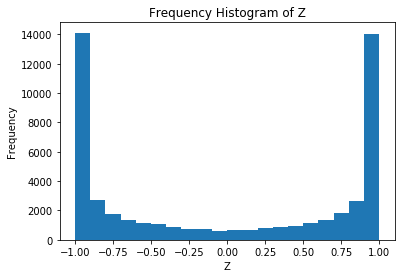

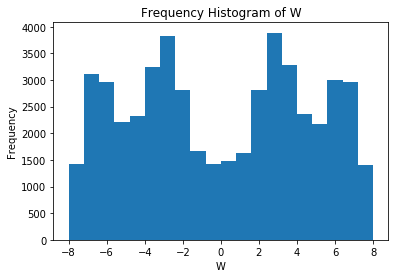

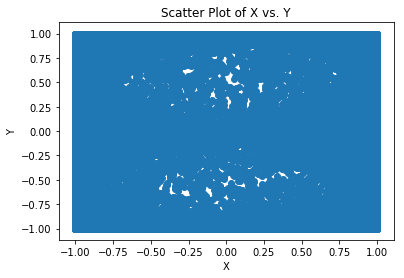

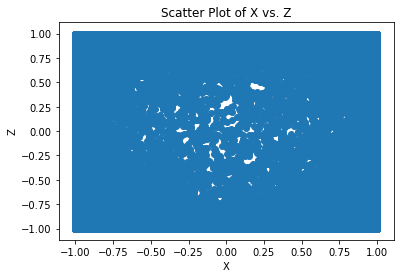

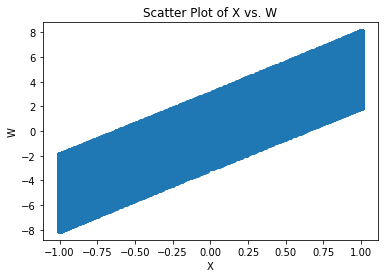

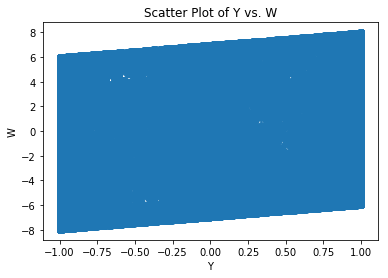

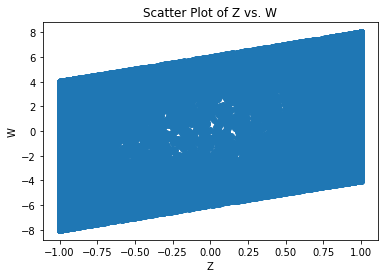

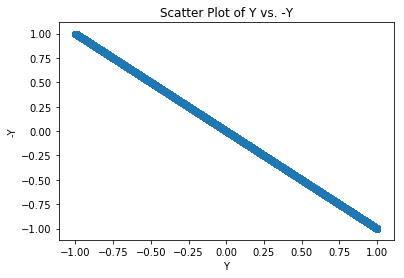

C:\Users\Pavan\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


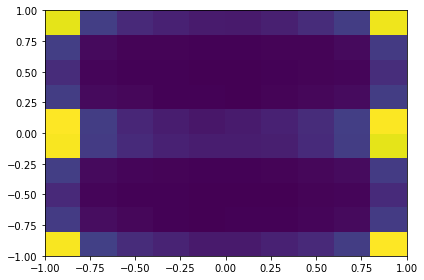

In [53]:
# Graphing stuff to make sure it's right
plt.hist(x, bins=20)
plt.title("Frequency Histogram of X")
plt.xlabel("X")
plt.ylabel("Frequency")
plt.show()
plt.hist(y, bins=20)
plt.title("Frequency Histogram of Y")
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.show()
plt.hist(z, bins=20)
plt.title("Frequency Histogram of Z")
plt.xlabel("Z")
plt.ylabel("Frequency")
plt.show()
plt.hist(w, bins=20)
plt.title("Frequency Histogram of W")
plt.xlabel("W")
plt.ylabel("Frequency")
plt.show()
plt.scatter(x, y)
plt.title("Scatter Plot of X vs. Y")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
plt.scatter(x, z)
plt.title("Scatter Plot of X vs. Z")
plt.xlabel("X")
plt.ylabel("Z")
plt.show()
plt.scatter(x, w)
plt.title("Scatter Plot of X vs. W")
plt.xlabel("X")
plt.ylabel("W")
plt.show()
plt.scatter(y, w)
plt.title("Scatter Plot of Y vs. W")
plt.xlabel("Y")
plt.ylabel("W")
plt.show()
plt.scatter(z, w)
plt.title("Scatter Plot of Z vs. W")
plt.xlabel("Z")
plt.ylabel("W")
plt.show()
plt.scatter(y, ym1)
plt.title("Scatter Plot of Y vs. -Y")
plt.xlabel("Y")
plt.ylabel("-Y")
plt.show()

In [59]:
# Finding number of wells and mutual info
print("X has " + str(find_wells(d1_bin(x, bins=20))) + " wells")
print("Y has " + str(find_wells(d1_bin(y, bins=20))) + " wells")
print("W has " + str(find_wells(d1_bin(w, bins=20))) + " wells")
print("C has " + str(find_wells(d1_bin(c, bins=20))) + " wells")
print("D has " + str(find_wells(d1_bin(d, bins=20))) + " wells")
print("E has " + str(find_wells(d1_bin(e, bins=20))) + " wells")
print("F has " + str(find_wells(d1_bin(f, bins=20))) + " wells")
print("X and Y: " + str(mutual_info(x, y)))
print("X and W: " + str(mutual_info(x, w)))
print("Y and W: " + str(mutual_info(y, w)))
print("X and 4X: " + str(mutual_info(x, x4)))
print("X and -4X: " + str(mutual_info(x, xm4)))

X has 2 wells
Y has 3 wells
W has 2 wells
C has 2 wells
D has 2 wells
E has 2 wells
F has 2 wells
X and Y: 0.9854302146737461
X and W: 0.6945376955278735
Y and W: 0.8881819500924354
X and 4X: 0.0
X and -4X: 0.0


In [48]:
def find_ops(old_ops, max_outputs=-1, min_val=-1):
    if max_outputs == -1 and min_val == -1:
        raise Exception("You\'re using find_ops wrong. No reduction will be done.'")
    elif max_outputs < 2:
        max_outputs = len(old_ops)
    elif min_val == -1:
        min_val = 0
    most = 0
    vals = [0, 0]
    for i in range(len(old_ops)):
        for j in range(i + 1, len(old_ops)):
            tmp = mutual_info(old_ops[i].traj, old_ops[j].traj)
            if tmp > most:
                most = tmp
                vals = [i, j]
                
    new_ops = [old_ops[vals[0]], old_ops[vals[1]]]
    
    info_check = True
    
    while ((len(new_ops) < max_outputs) and (info_check)):
        
        print("ITERATION:")
        for i in new_ops:
            print(i)
        print("FIN")
        print()
        global data_array
        data_array = []
        for i in range(len(new_ops[0].traj)):
            x = [j.traj[i] for j in new_ops]
            data_array.append(x.copy())
        consistent = True
        candidate_wells = 2

        while (consistent == True):

            print("Testing " + str(candidate_wells) + " wells")
            
            global nfev, lastf, last

            guess = initial_guess(candidate_wells, len(new_ops), data_array)

            sgoop.wells = candidate_wells
            start = time.time()
            last = start
            lastf = nfev = 0
            minimizer_kwargs = {"options": {"maxiter":10}}
            ret = opt.basinhopping(opti_func,guess,niter=100,T=.01,stepsize=.1, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
            end = time.time()
            prob_space = sgoop.md_prob(ret.x, data_array)

            if (find_wells(prob_space) >= candidate_wells):
                print(str(candidate_wells) + " well runs accepted. Testing " + str(candidate_wells + 1) + " well RC.")
                rc = ret.x.copy()
                candidate_wells = candidate_wells + 1
            else:
                print(str(candidate_wells) + " well runs failed. Reverting to previous RC.")
                if candidate_wells == 2:
                    rc = ret.x.copy()
                consistent = False
        
        proj = []
        for v in data_array:
            proj.append(np.dot(np.array(v),rc))
        most = 0
        newest_op = None
        
        p=sgoop.md_prob(rc, data_array)
        plt.plot(-np.ma.log(p))
        plt.show()
        
        for i in old_ops:
            exists = False
            for j in new_ops:
                if i.i == j.i and i.j == j.j:
                    exists = True
                    break;
            if exists == True:
                continue;
            tmp = mutual_info(i.traj, proj)
            if tmp > most:
                most = tmp
                newest_op = i
        if most > min_val:
            new_ops.append(newest_op)
    
    return new_ops

ITERATION:
10
19
FIN

Testing 2 wells
2 well runs accepted. Testing 3 well RC.
Testing 3 wells
3 well runs accepted. Testing 4 well RC.
Testing 4 wells
4 well runs accepted. Testing 5 well RC.
Testing 5 wells
5 well runs failed. Reverting to previous RC.


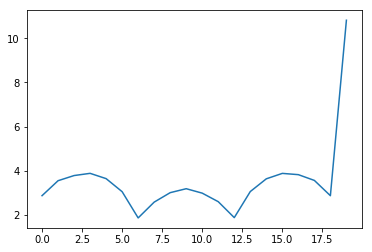

ITERATION:
10
19
13
FIN

Testing 2 wells
2 well runs failed. Reverting to previous RC.


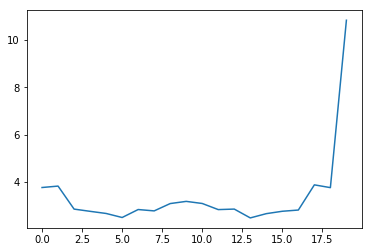

ITERATION:
10
19
13
12
FIN

Testing 2 wells
2 well runs failed. Reverting to previous RC.


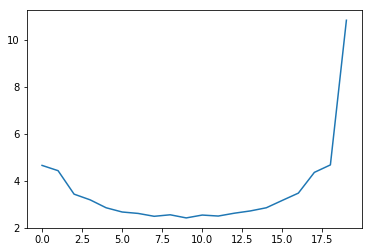

HERE ARE THE SELECTED OPS:
10
19
13
12
0


In [57]:
tmp = [x, x2, x4, x5, xm1, xm4, y, y2, y4, y5, ym1, ym4, z, a, a2, a3, am1, am2, am3, b, b2, b3, bm1, bm2, bm3]
# 0 - x
# 10 - ym1
# 12 - z
# 13 - a
# 19 - b
ops = [OrderParameter(i, i, tmp[i]) for i in range(len(tmp))]
vals = find_ops(ops, max_outputs=5)
print("HERE ARE THE SELECTED OPS:")
for i in vals:
    print(i)

ITERATION:
7
22
FIN

Testing 2 wells
2 well runs failed. Reverting to previous RC.


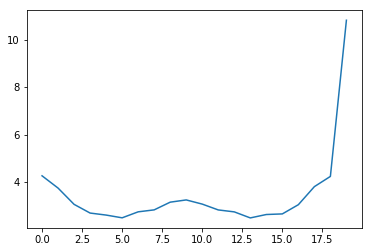

ITERATION:
7
22
6
FIN

Testing 2 wells
2 well runs accepted. Testing 3 well RC.
Testing 3 wells
3 well runs failed. Reverting to previous RC.


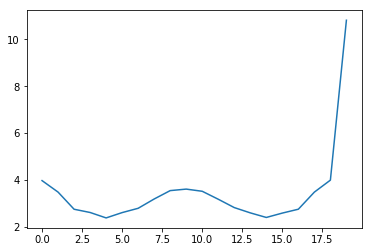

ITERATION:
7
22
6
13
FIN

Testing 2 wells
2 well runs failed. Reverting to previous RC.


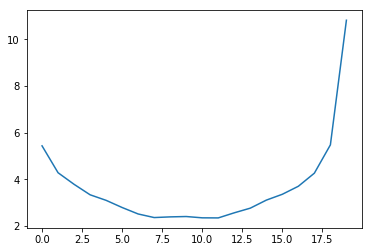

HERE ARE THE SELECTED OPS:
7
22
6
13
15


In [60]:
tmp = [x, x2, x4, x5, xm1, xm4, y, w, y2, y4, y5, ym1, c, d, ym4, z, a, a2, a3, am1, am2, am3, e, b, b2, b3, bm1, f, bm2, bm3]
# 6 - y (tmp2)
# 7 - w (Tmp1, tmp2)
# 13 - d (tmp3, Tmp4)
# 15 - z (tmp3)
# 22 - e (tmp3, tmp4, Tmp5)
ops = [OrderParameter(i, i, tmp[i]) for i in range(len(tmp))]
vals = find_ops(ops, max_outputs=5)
print("HERE ARE THE SELECTED OPS:")
for i in vals:
    print(i)